# Ensemble Level LSTM Model

In [100]:
from __future__ import print_function
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import datetime
import pickle
from sklearn import datasets, metrics, cross_validation
from urllib import urlretrieve
import matplotlib.pyplot as plt
import random
from itertools import permutations

URL = "https://github.com/anucc/metatone-analysis/raw/master/metadata/"
PICKLE_FILE = "metatone_performances_dataframe.pickle"

if not os.path.exists(PICKLE_FILE):
    urlretrieve(URL + PICKLE_FILE, PICKLE_FILE)

with open(PICKLE_FILE, 'rb') as f:
        metatone_dataset = pickle.load(f)
        
## Int values for Gesture codes.
NUMBER_GESTURES = 9
GESTURE_CODES = {
    'N': 0,
    'FT': 1,
    'ST': 2,
    'FS': 3,
    'FSA': 4,
    'VSS': 5,
    'BS': 6,
    'SS': 7,
    'C': 8}

vocabulary_size = len(GESTURE_CODES)

In [117]:
## Isoloate Individual Performances
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration") &
    (metatone_dataset["number_performers"] != 4)]
gesture_data = improvisations['gestures']
individual_improvisations = []
for perf in gesture_data.tolist():
    for one_perf in perf.T:
        individual_improvisations.append(one_perf)
print("Number of performances for testing: ", len(individual_improvisations))
        
## Isolate the Interesting Ensemble Performances
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration") &
    (metatone_dataset["number_performers"] == 4)]
gesture_data = improvisations['gestures']
#metatone_dataset["number_performers"]


num_input_performers = 4
num_output_performers = 3

ensemble_improvisations = gesture_data.tolist()

def encode_ensemble_gestures(gestures):
    """Encode multiple natural numbers into one"""
    encoded = 0
    for i, g in enumerate(gestures):
        encoded += g * (vocabulary_size ** i)
    return encoded
        
def decode_ensemble_gestures(num_perfs,code):
    gestures = []
    for i in range(num_perfs):
        part = code % (vocabulary_size ** (i+1))
        gestures.append(part / (vocabulary_size ** i))
    return gestures

## Setup the epochs
## Each batch is of single gestures as input and tuples of remaining performers as output
def generate_epochs(num_epochs, num_steps, batch_size):
    ## Setup the inputs and label sets
    imp_xs = []
    imp_ys = []
    
    for imp in ensemble_improvisations:
        for i in range(len(imp)-num_steps-1):
            imp_slice = imp[i:i+num_steps+1]
            for j in range(len(imp_slice.T)):
                lead = imp_slice[1:].T[j] # lead gestures (post steps)
                ensemble = imp_slice.T[np.arange(len(imp_slice.T)) != j] # rest of the players indexed by player
                for ens_perm in permutations(ensemble): # consider all permutations of the players
                    ens_pre = np.array(ens_perm).T[:-1] # indexed by time slice
                    ens_post = np.array(ens_perm).T[1:] # indexed by time slice
                    y = map(encode_ensemble_gestures,ens_post)
                    #y = ens_post # test just show the gestures
                    x = map(encode_ensemble_gestures,zip(lead,*(ens_pre.T))) # encode ensemble state
                    #x = zip(lead,*(ens_pre.T)) # test just show the gestures
                    imp_xs.append(x) # append the inputs
                    imp_ys.append(y) # append the outputs
    dataset = zip(imp_xs,imp_ys)
    print("Total Training Examples: " + str(len(imp_xs)))
    print("Total Training Labels: " + str(len(imp_ys)))
    epochs = []
    for j in range(num_epochs):
        # shutffle the big list
        np.random.shuffle(dataset)
        dataset_size = len(dataset)
        batches = []
        for i in range(dataset_size / batch_size):
            ## Setup the batches
            batch = dataset[i*batch_size:(i+1)*batch_size]
            bx,by = zip(*batch)
            batches.append((np.array(bx),np.array(by)))
        epochs.append(batches)
    return epochs

# Test 
#t = time.time()
#a = generate_epochs(1,20,15)
#t1 = time.time()-t
#print("that took: " + str(t1))
#e1 = a[0]
#e2 = a[1]
#print(e1[0][0])
#print(e1[0][1])
#y1 = e1[0][1][15]
#print(y1)


Number of performances for testing:  120


In [102]:
#print((np.array(a)).shape)
#print("Xs")
#print(a[0][0][0])
#print("Ys")
#print(a[0][0][1])

In [104]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## Training Network
## Hyperparameters for training
num_nodes = 512 # tried could be 64--512
num_classes = vocabulary_size

num_input_classes = vocabulary_size ** num_input_performers
num_output_classes = vocabulary_size ** num_output_performers
batch_size = 64
num_steps = 120
num_layers = 3
learning_rate = 1e-4

#def load_graph():
#graph = tf.Graph()
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_input_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Num Input Classes: " + str(num_input_classes))
    print("Num Output Classes: " + str(num_output_classes))
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))



Graph Specs:
Num Input Classes: 6561
Num Output Classes: 729
Inputs: Tensor("embedding_lookup:0", shape=(64, 120, 512), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(7680, 512), dtype=float32)
Logits: Tensor("add:0", shape=(7680, 729), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(7680, 729), dtype=float32)


### Training

In [105]:
num_epochs = 30
tf.set_random_seed(2345)

model_name = "quartet-lstm-model-" + str(num_nodes) + "-" + str(num_epochs) +  "-epochs.tfsave"
print("Going to train: " + model_name)
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    training_losses = []
    print("Starting Training")
    for i, epoch in enumerate(generate_epochs(num_epochs, num_steps, batch_size)):
        ## Setup for each epoch
        training_loss = 0
        steps = 0
        training_state = None
        print("Starting Epoch " + str(i) + " of " + str(num_epochs))
        for batch_data, batch_labels in epoch:
            #print(batch_data.shape)
            #print(batch_labels.shape)
            ## Setup for each batch
            feed = {x:batch_data, y:batch_labels}
            if training_state is not None:
                feed[init_state] = training_state
            #print(str(feed))
            ## Evaluate the train step
            training_loss_current, training_state, _ = sess.run([total_loss,final_state,train_step],feed_dict=feed)
            steps += 1
            training_loss += training_loss_current
            if (steps % 2000 == 0): 
                print("Trained batch: " + str(steps) + " of " + str(len(epoch)) + " loss was: " + str(training_loss_current))
        print("Trained Epoch " + str(i) + " of " + str(num_epochs))
        training_losses.append(training_loss/steps)
    ## Save the results
    print("Finished Training, Saving Model.")
    saver.save(sess,model_name)
    print("Model was saved.")
    #tf.train.Saver()

print("It took ", time.time() - start_time, " to train the network.")

Going to train: quartet-lstm-model-512-30-epochs.tfsave
Starting Training
Total Training Examples: 361560
Total Training Labels: 361560
Starting Epoch 0 of 30
Trained batch: 2000 of 5649 loss was: 1.9823
Trained batch: 4000 of 5649 loss was: 1.48678
Trained Epoch 0 of 30
Starting Epoch 1 of 30
Trained batch: 2000 of 5649 loss was: 1.0191
Trained batch: 4000 of 5649 loss was: 0.765944
Trained Epoch 1 of 30
Starting Epoch 2 of 30
Trained batch: 2000 of 5649 loss was: 0.672126
Trained batch: 4000 of 5649 loss was: 0.550169
Trained Epoch 2 of 30
Starting Epoch 3 of 30
Trained batch: 2000 of 5649 loss was: 0.442875
Trained batch: 4000 of 5649 loss was: 0.36646
Trained Epoch 3 of 30
Starting Epoch 4 of 30
Trained batch: 2000 of 5649 loss was: 0.370439
Trained batch: 4000 of 5649 loss was: 0.328485
Trained Epoch 4 of 30
Starting Epoch 5 of 30
Trained batch: 2000 of 5649 loss was: 0.290727
Trained batch: 4000 of 5649 loss was: 0.26735
Trained Epoch 5 of 30
Starting Epoch 6 of 30
Trained batch:

Epoch vs Training Losses


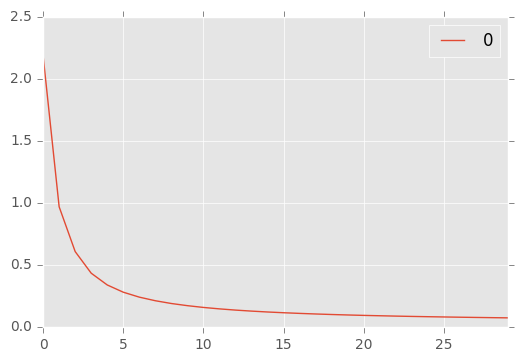

In [106]:
## Plot Training Results:
a = pd.DataFrame(training_losses)
print("Epoch vs Training Losses")
plt.show(a.plot())

### Generating

In [107]:
## Evaluating Network

#model_name = "ensemble-lstm-model-10-epochs.tfsave"

batch_size = 1
num_steps = 1

## Reload the graph
## Training Network
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_input_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Num Input Classes: " + str(num_input_classes))
    print("Num Output Classes: " + str(num_output_classes))
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))

def plot_gesture_only_score(plot_title, gestures):
    """
    Plots a gesture score of gestures only
    """
    idx = gestures.index
    plt.style.use('ggplot')
    ax = plt.figure(figsize=(14, 4), frameon=False, tight_layout=True).add_subplot(111)
    ax.yaxis.grid()
    plt.ylim(-0.5, 8.5)
    plt.yticks(np.arange(9), ['n', 'ft', 'st', 'fs', 'fsa', 'vss', 'bs', 'ss', 'c'])
    for n in gestures.columns:
        plt.plot(gestures.index, gestures[n], '-', label=n)
    #plt.savefig(plot_title.replace(":", "_") + '.pdf', dpi=150, format="pdf")
    #plt.close()
    plt.show()

Graph Specs:
Num Input Classes: 6561
Num Output Classes: 729
Inputs: Tensor("embedding_lookup:0", shape=(1, 1, 512), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(1, 512), dtype=float32)
Logits: Tensor("add:0", shape=(1, 729), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(1, 729), dtype=float32)


In [108]:
print(model_name)

quartet-lstm-model-512-30-epochs.tfsave


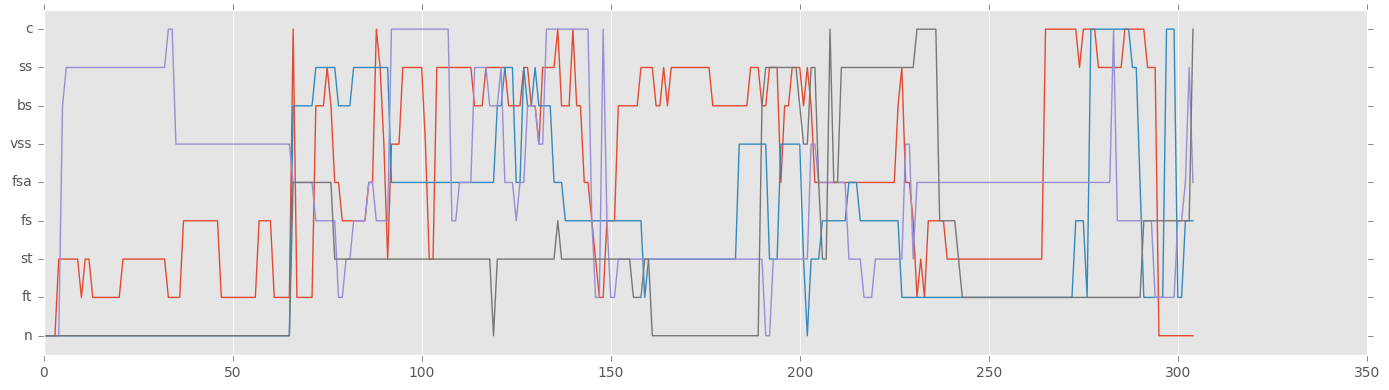

In [110]:
num_performances = 1
generated_performance = pd.DataFrame()
player_one = random.choice(individual_improvisations)
generated_performance["player1"] = player_one
player_one = player_one.tolist()

with tf.Session() as sess:
    # possibly restore all variables
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, "./"+model_name)
    
    # start generating output
    state = None
    output_perf = []
    output_gestures = decode_ensemble_gestures(num_output_performers,0)
    
    for current_step in player_one:
        gesture_inputs = list(output_gestures)
        gesture_inputs.insert(0,current_step)
        if state is not None:
            feed_dict = {x: [[encode_ensemble_gestures(gesture_inputs)]], init_state: state}
        else:
            feed_dict = {x: [[encode_ensemble_gestures(gesture_inputs)]]}
        preds,state = sess.run([predictions,final_state],feed_dict=feed_dict)
        output_step = np.random.choice(num_output_classes,1,p=np.squeeze(preds))[0] # choose the output step
        output_gestures = decode_ensemble_gestures(num_output_performers,output_step)
        output_perf.append(output_gestures)

out = np.array(output_perf)
len(out.T)
for i, seq in enumerate(out.T):
    generated_performance[i] = seq

#output_perf = pd.DataFrame({j:output_perf})
#generated_performance[j] = output_perf[j]

#generated_performance.to_csv("100epoch-ensemble-performances")   
plot_gesture_only_score("quartet-performance", generated_performance)

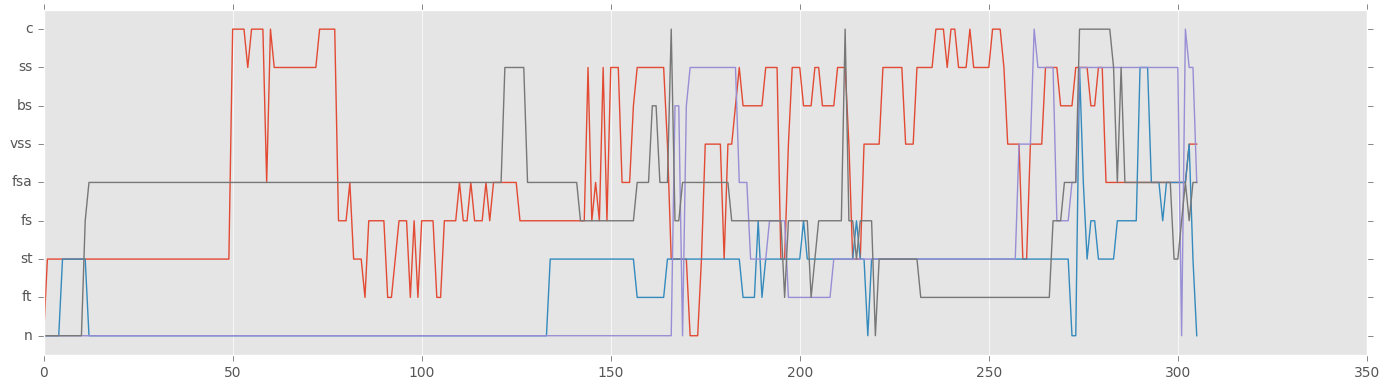

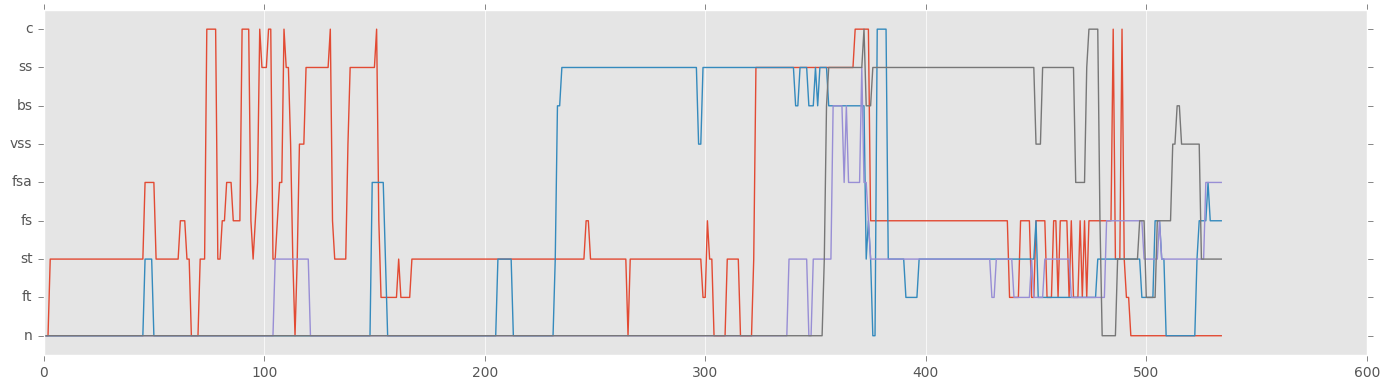

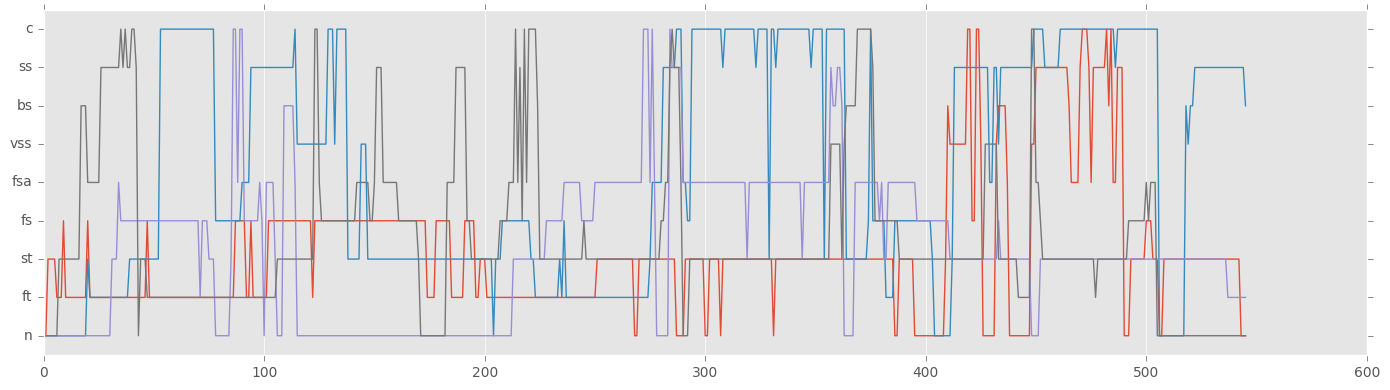

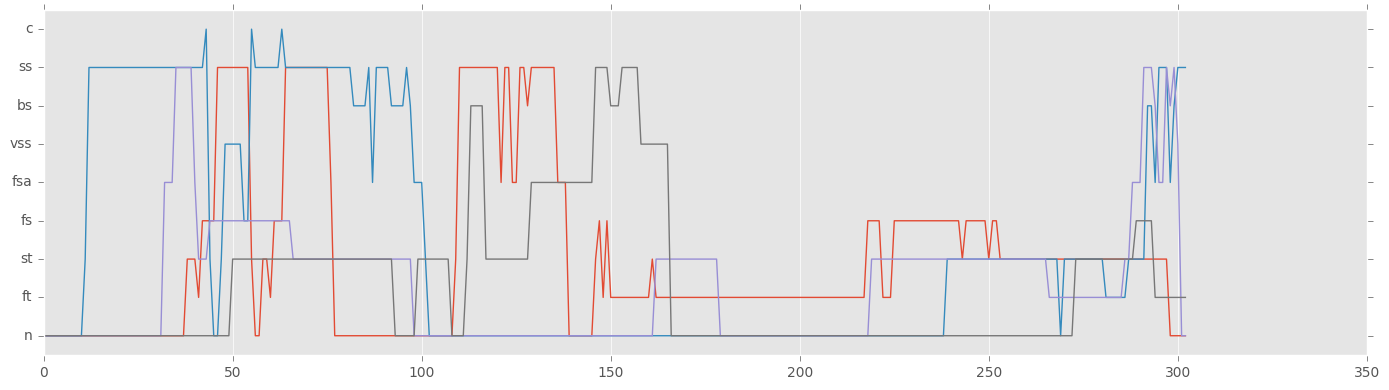

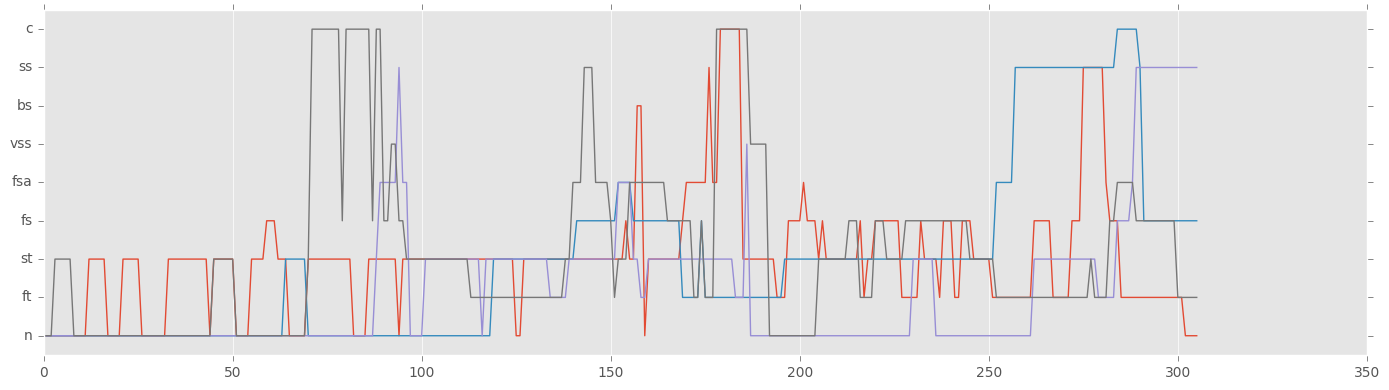

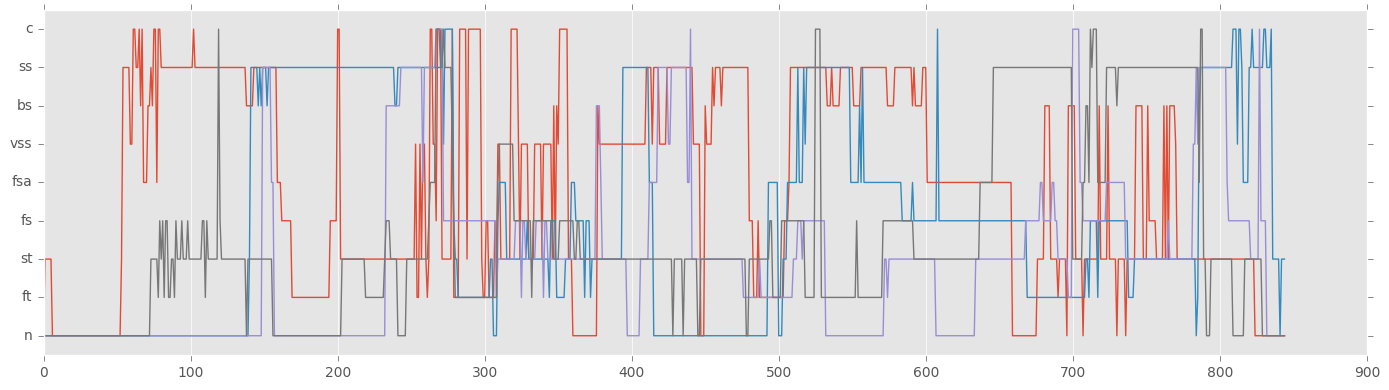

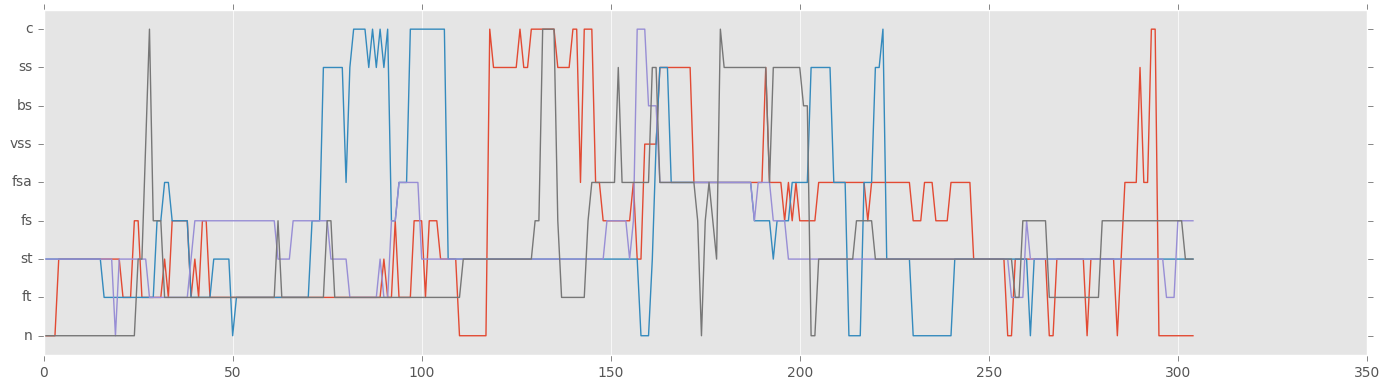

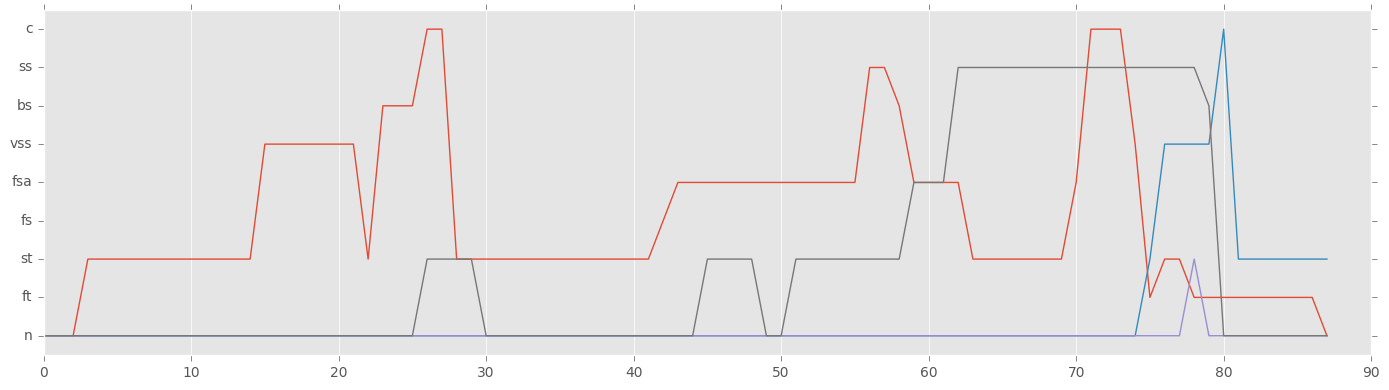

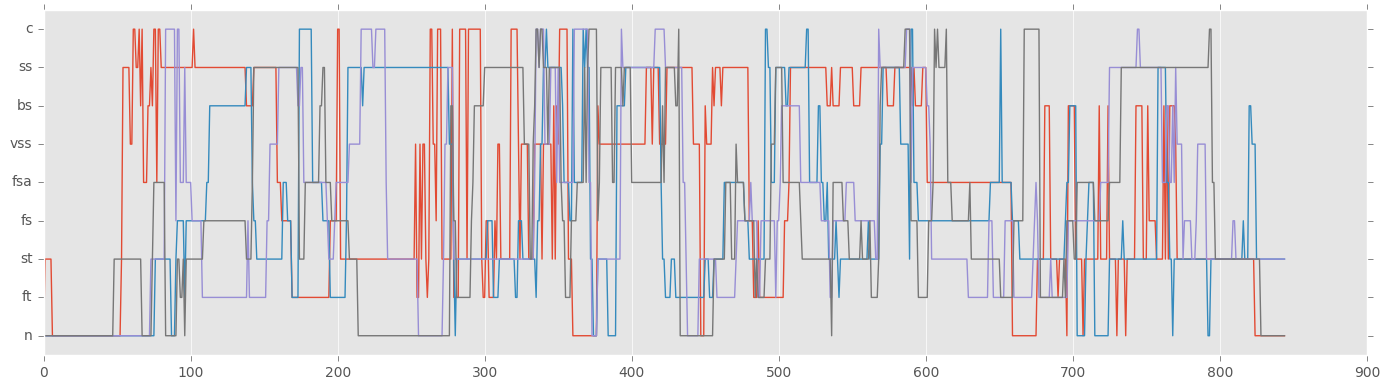

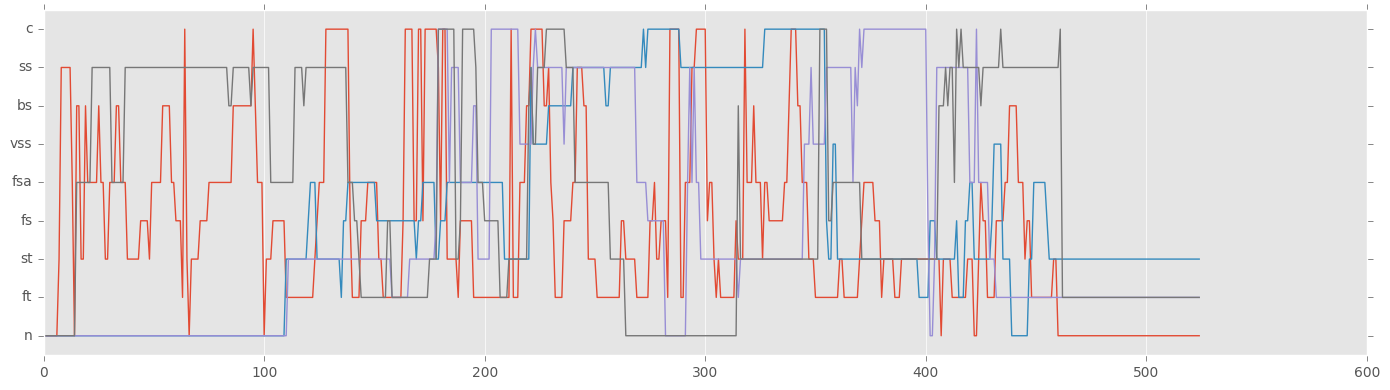

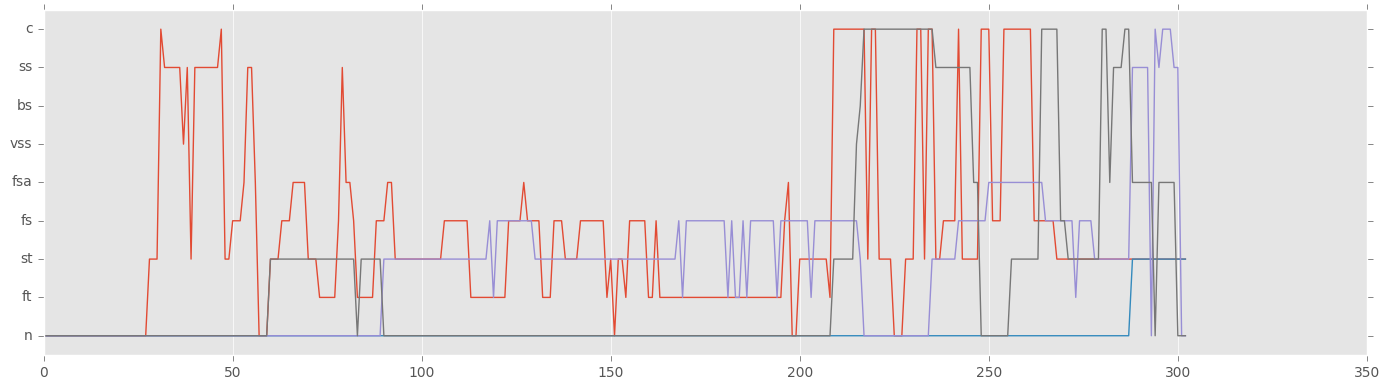

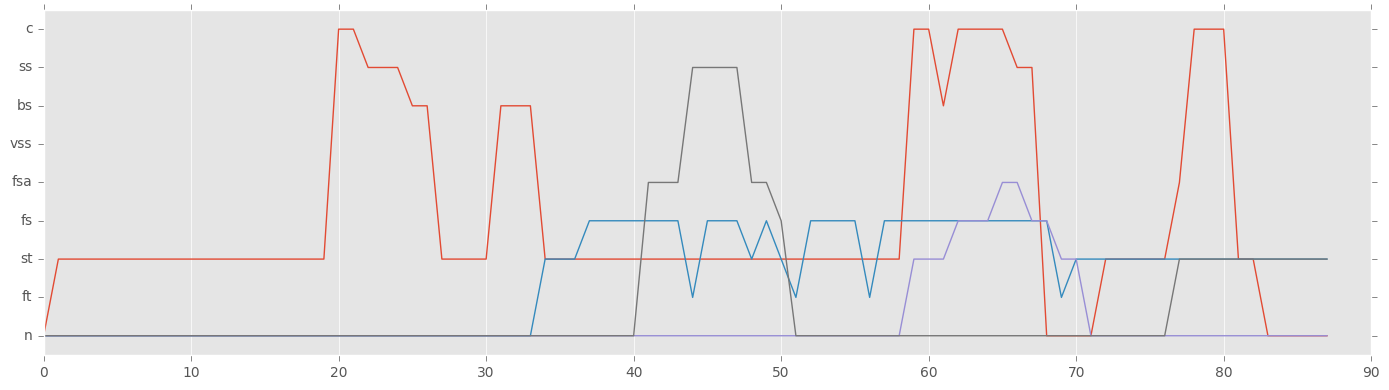

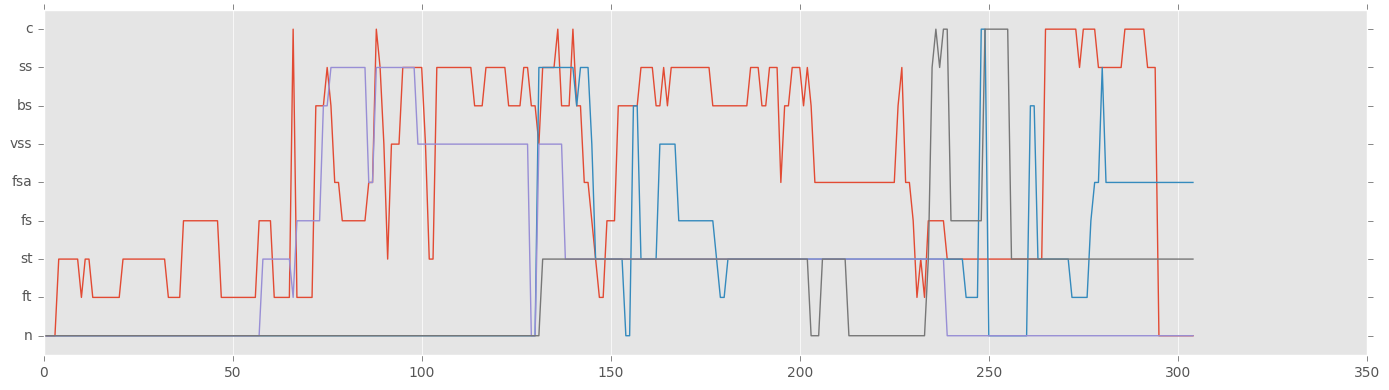

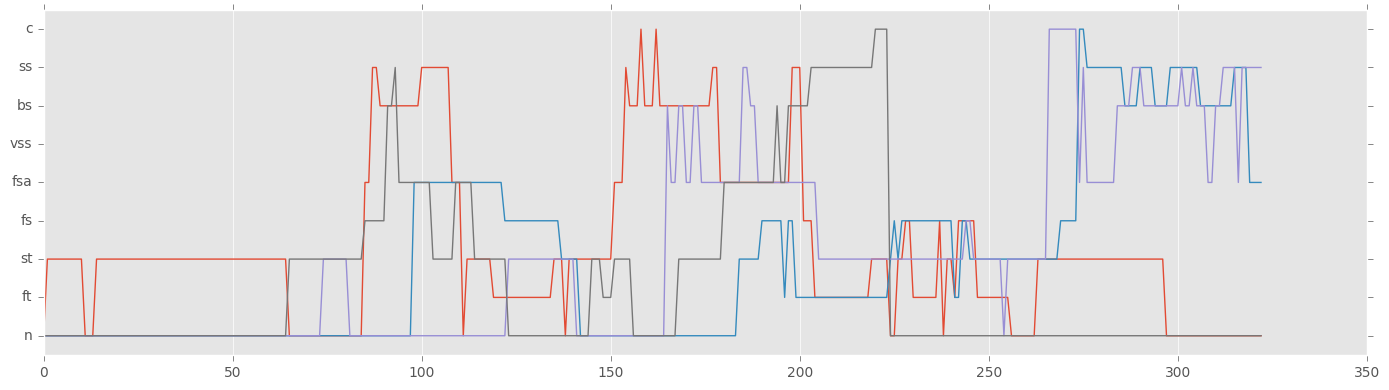

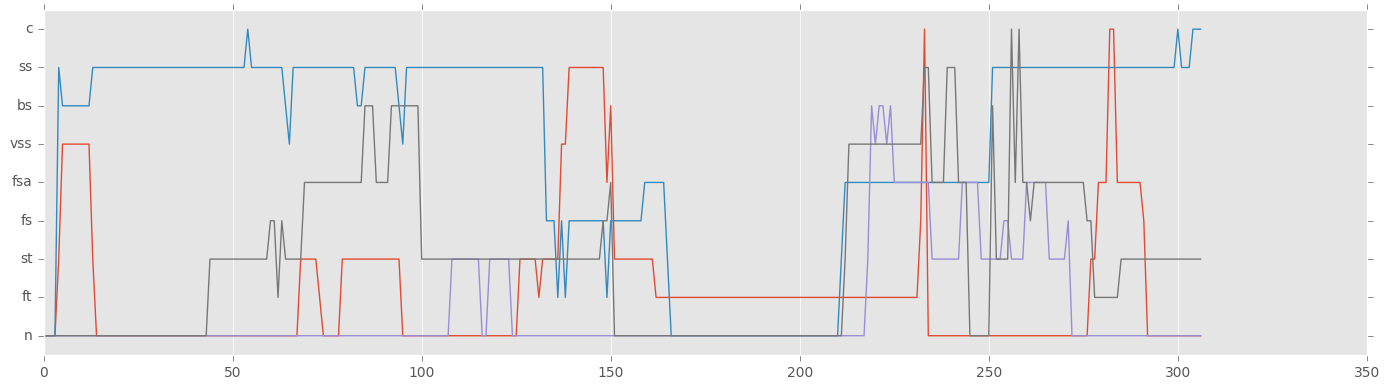

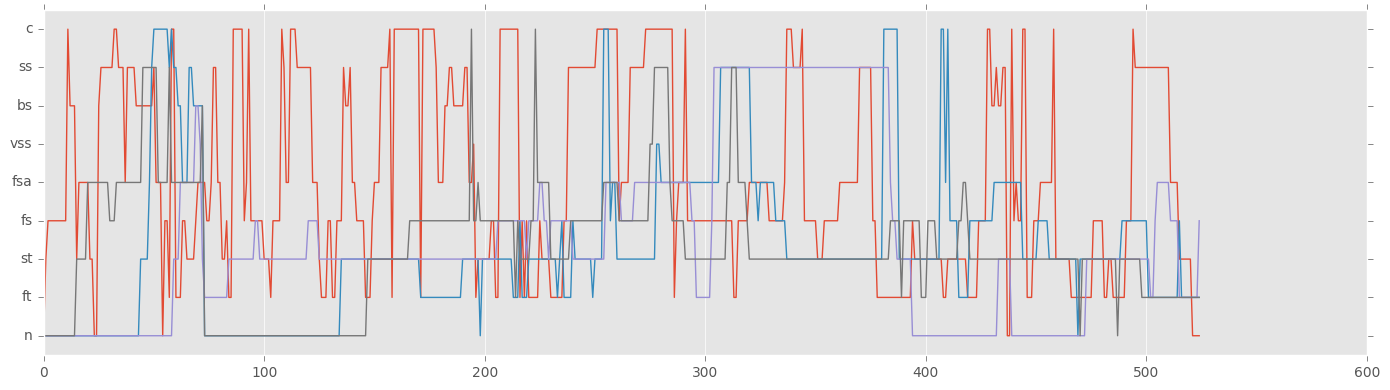

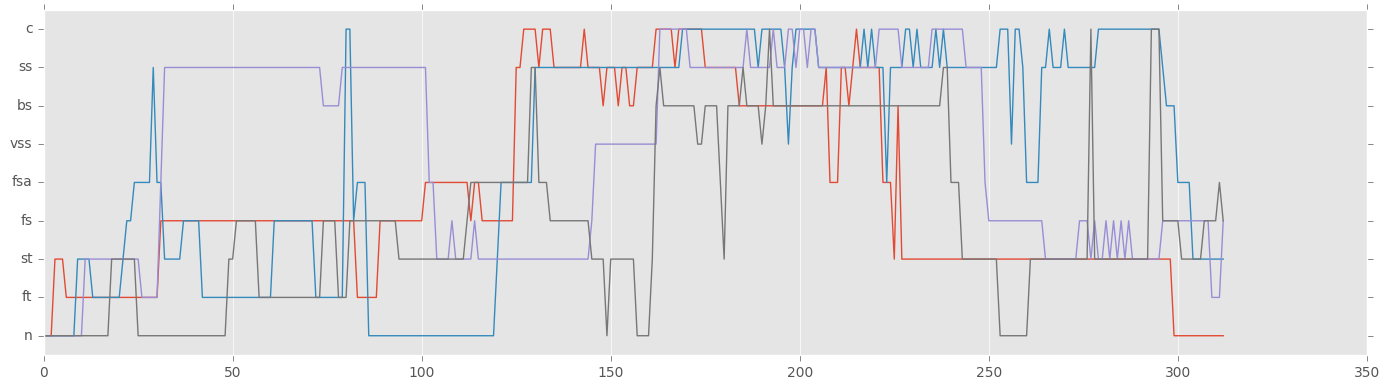

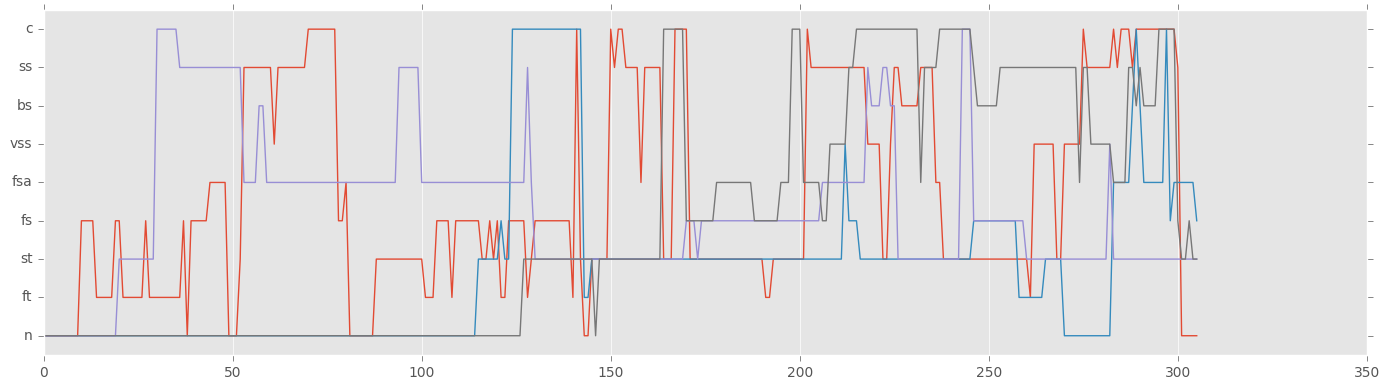

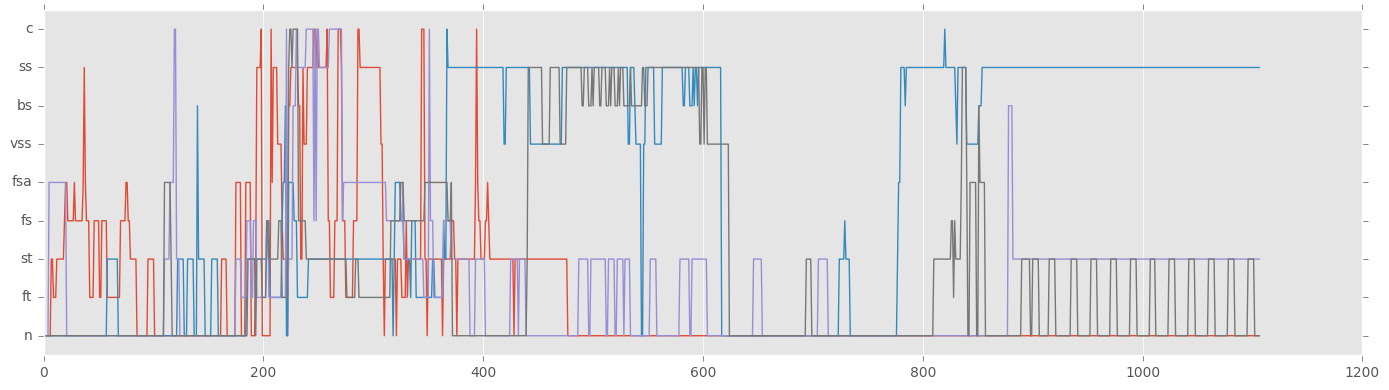

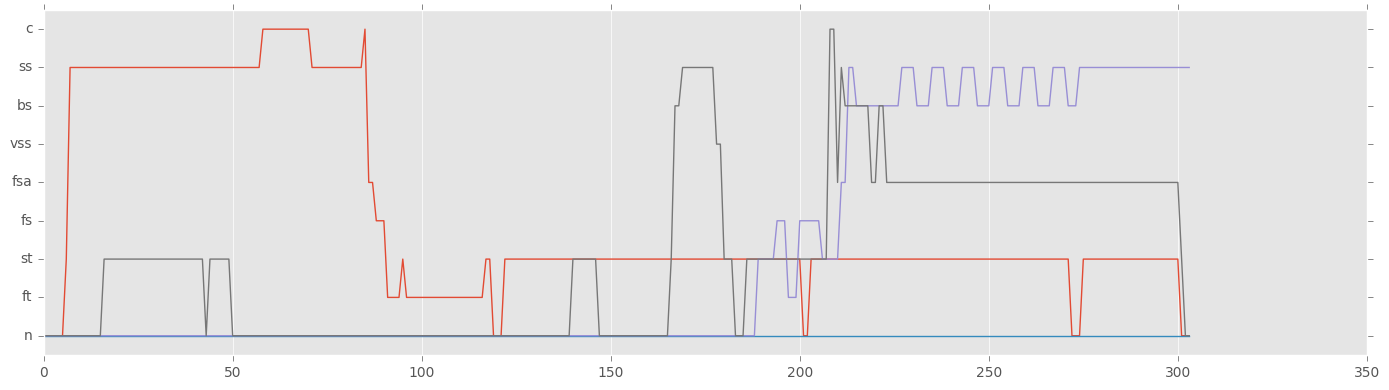

In [119]:
def plot_gesture_only_score(plot_title, gestures):
    """
    Plots a gesture score of gestures only - no new ideas!
    """
    idx = gestures.index
    plt.style.use('ggplot')
    # ax = plt.figure(figsize=(35,10),frameon=False,tight_layout=True).add_subplot(111)
    ax = plt.figure(figsize=(14, 4), frameon=False, tight_layout=True).add_subplot(111)
    #ax.xaxis.set_major_locator(dates.SecondLocator(bysecond=[0]))
    #ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    ax.yaxis.grid()
    plt.ylim(-0.5, 8.5)
    plt.yticks(np.arange(9), ['n', 'ft', 'st', 'fs', 'fsa', 'vss', 'bs', 'ss', 'c'])
    for n in gestures.columns:
        plt.plot(gestures.index, gestures[n], '-', label=n)
    # plt.legend(loc='upper right')
    plt.savefig(plot_title + '.pdf', dpi=150, format="pdf")
    #plt.close()
    plt.show()

for n in range(20):    
    num_performances = 1
    generated_performance = pd.DataFrame()
    player_one = random.choice(individual_improvisations)
    generated_performance["player1"] = player_one
    player_one = player_one.tolist()

    with tf.Session() as sess:
        # possibly restore all variables
        sess.run(tf.initialize_all_variables())
        saver.restore(sess, "./"+model_name)

        # start generating output
        state = None
        output_perf = []
        output_gestures = decode_ensemble_gestures(num_output_performers,0)

        for current_step in player_one:
            gesture_inputs = list(output_gestures)
            gesture_inputs.insert(0,current_step)
            if state is not None:
                feed_dict = {x: [[encode_ensemble_gestures(gesture_inputs)]], init_state: state}
            else:
                feed_dict = {x: [[encode_ensemble_gestures(gesture_inputs)]]}
            preds,state = sess.run([predictions,final_state],feed_dict=feed_dict)
            output_step = np.random.choice(num_output_classes,1,p=np.squeeze(preds))[0] # choose the output step
            output_gestures = decode_ensemble_gestures(num_output_performers,output_step)
            output_perf.append(output_gestures)

    out = np.array(output_perf)
    len(out.T)
    for i, seq in enumerate(out.T):
        generated_performance[i] = seq

    #output_perf = pd.DataFrame({j:output_perf})
    #generated_performance[j] = output_perf[j]

    #generated_performance.to_csv("100epoch-ensemble-performances")   
    plot_gesture_only_score("quartet-performance-512nodes-"+str(n), generated_performance)


In [87]:
generated_performance.to_csv("test-ensemble-performance-100epoch.csv")


In [112]:
pwd

u'/home/charles/src/ensemble-performance-deep-models'